target
16    100
10    100
4     100
5     100
15    100
9     100
7     100
2     100
11    100
3     100
0     100
8     100
12    100
6     100
13     74
14     50
1      46
Name: count, dtype: int64


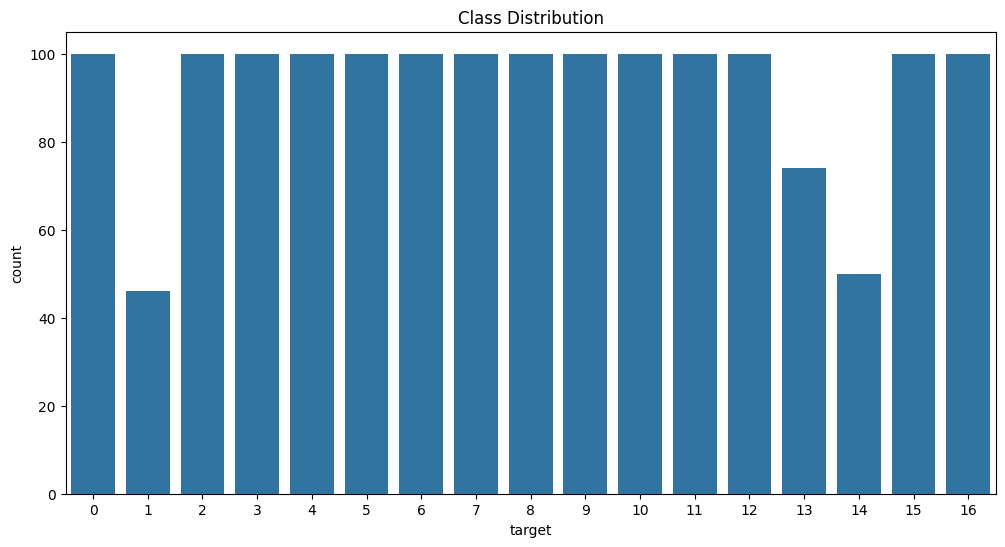

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. train.csv 파일을 불러옵니다. (경로는 본인 환경에 맞게 확인)
csv_path = '/root/cv_project/datasets/data/train.csv'
df = pd.read_csv(csv_path)

# 2. 클래스별 데이터 개수를 셉니다.
print(df['target'].value_counts())

# 3. 막대그래프로 시각화합니다.
plt.figure(figsize=(12, 6))
sns.countplot(x='target', data=df)
plt.title('Class Distribution')
plt.show()

Checking image sizes: 100%|██████████| 1570/1570 [00:00<00:00, 17396.39it/s]

             width       height
count  1570.000000  1570.000000
mean    497.613376   538.169427
std      79.370316    76.074772
min     384.000000   348.000000
25%     443.000000   443.000000
50%     443.000000   591.000000
75%     591.000000   591.000000
max     753.000000   682.000000


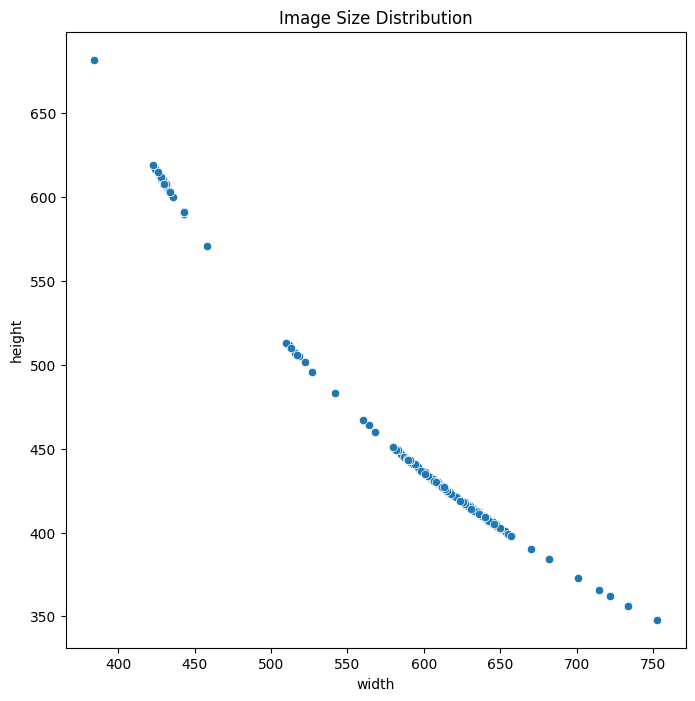

In [3]:
import os
from PIL import Image
from tqdm import tqdm

img_folder_path = '/root/cv_project/datasets/data/train/'
img_paths = [os.path.join(img_folder_path, fname) for fname in df['ID']]

sizes = []
# tqdm은 진행률을 보여줍니다.
for path in tqdm(img_paths, desc="Checking image sizes"):
    with Image.open(path) as img:
        sizes.append(img.size) # (width, height)

# pandas DataFrame으로 변환하여 통계 확인
size_df = pd.DataFrame(sizes, columns=['width', 'height'])
print(size_df.describe())

# scatter plot으로 분포 시각화
plt.figure(figsize=(8, 8))
sns.scatterplot(x='width', y='height', data=size_df)
plt.title('Image Size Distribution')
plt.show()

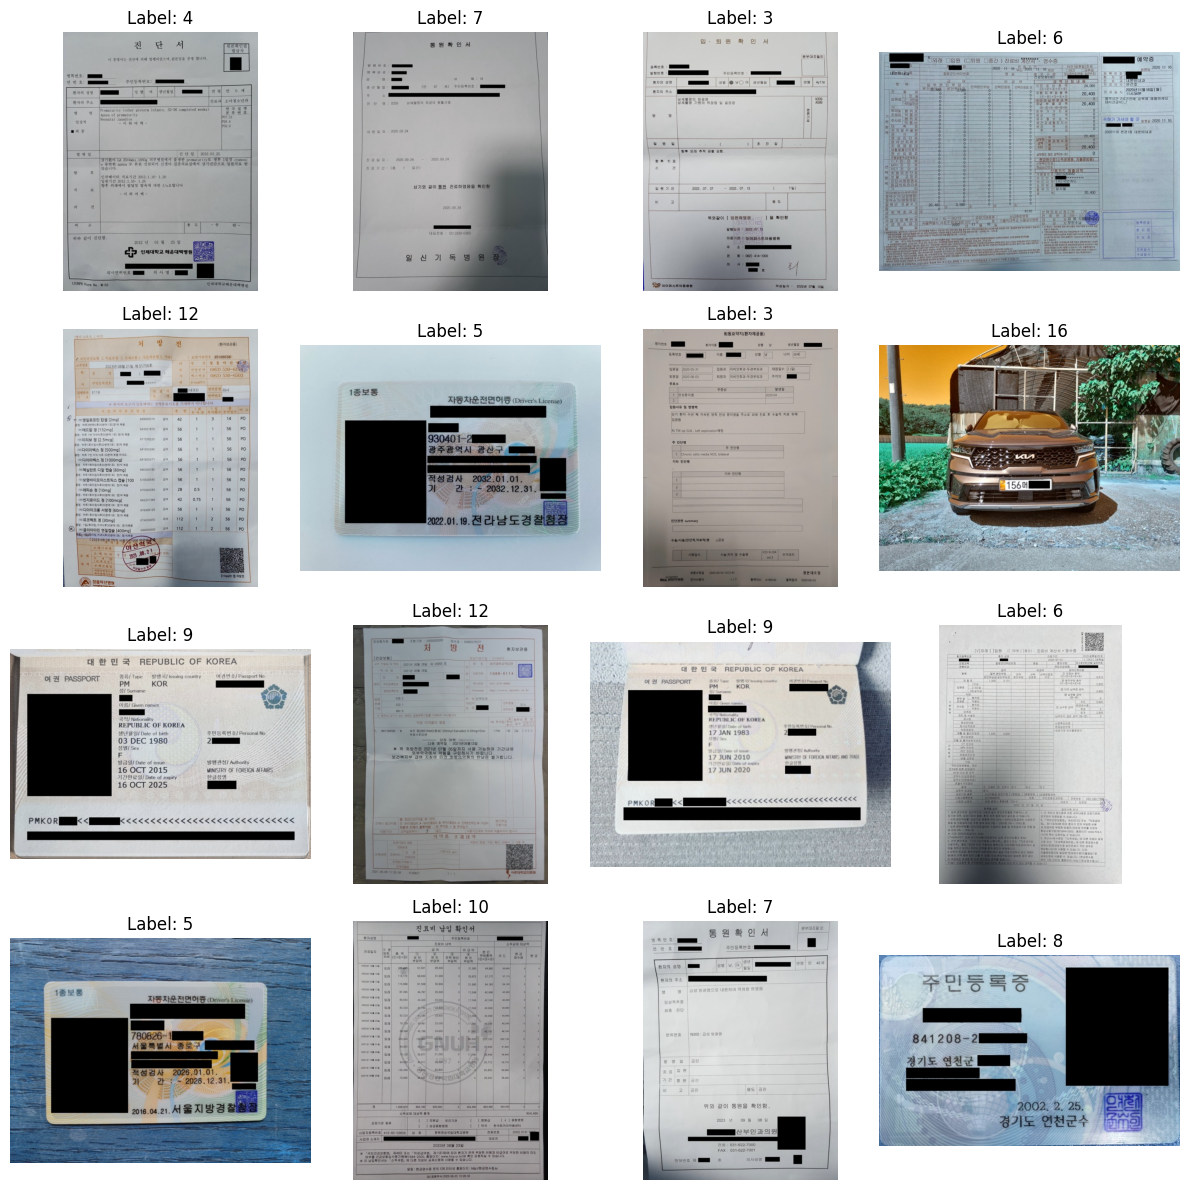

In [5]:
# 1. 랜덤으로 16개의 샘플을 뽑습니다.
sample_df = df.sample(16)

plt.figure(figsize=(12, 12))
for i, (index, row) in enumerate(sample_df.iterrows()):
    img_path = os.path.join(img_folder_path, row['ID'])
    label = row['target']
    
    # 4x4 그리드의 i+1 번째 위치에 이미지를 그립니다.
    plt.subplot(4, 4, i+1)
    
    # 이미지 열기
    img = Image.open(img_path)
    plt.imshow(img)
    
    # 제목에 라벨 표시
    plt.title(f"Label: {label}")
    plt.axis('off') # 축 정보는 끕니다.

plt.tight_layout()
plt.show()

Checking file existence for train data...
Extracting features from 1570 train images...


100%|██████████| 1570/1570 [00:03<00:00, 484.02it/s]


Checking file existence for test data...
Extracting features from 3140 test images...


100%|██████████| 3140/3140 [00:06<00:00, 459.04it/s]



Feature extraction complete. Generating plots...


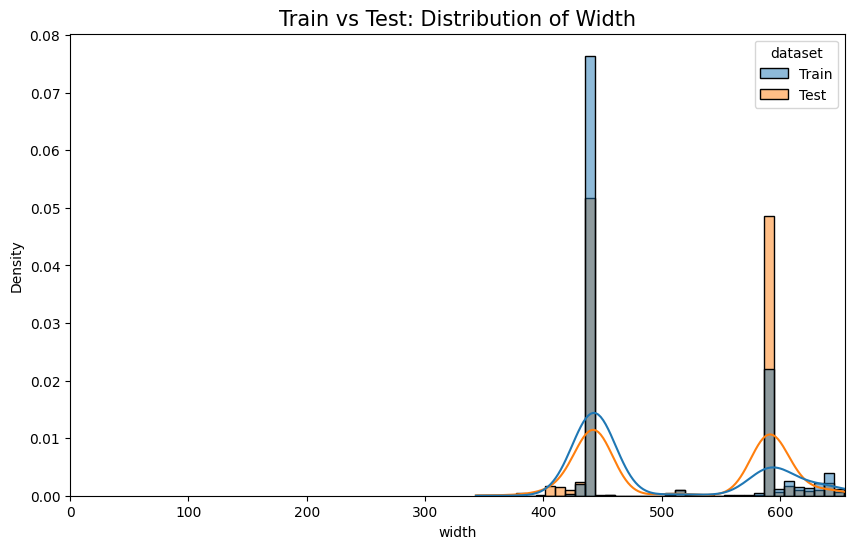

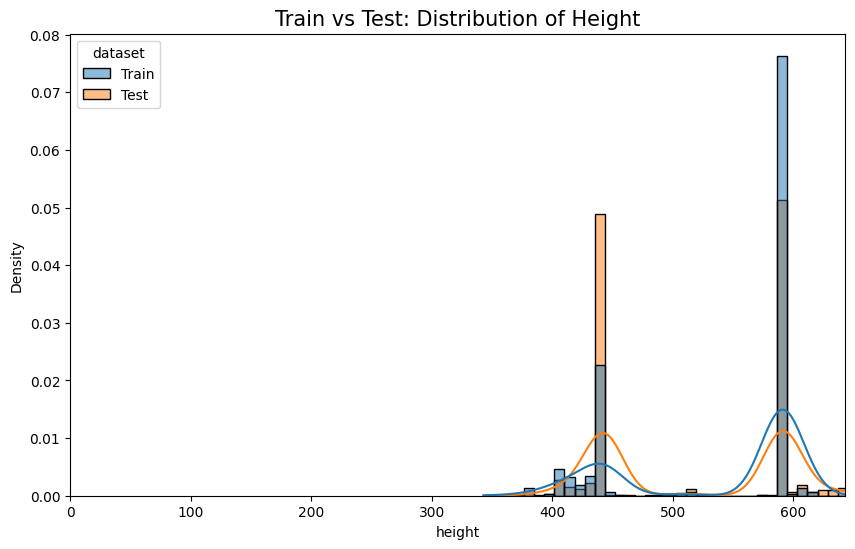

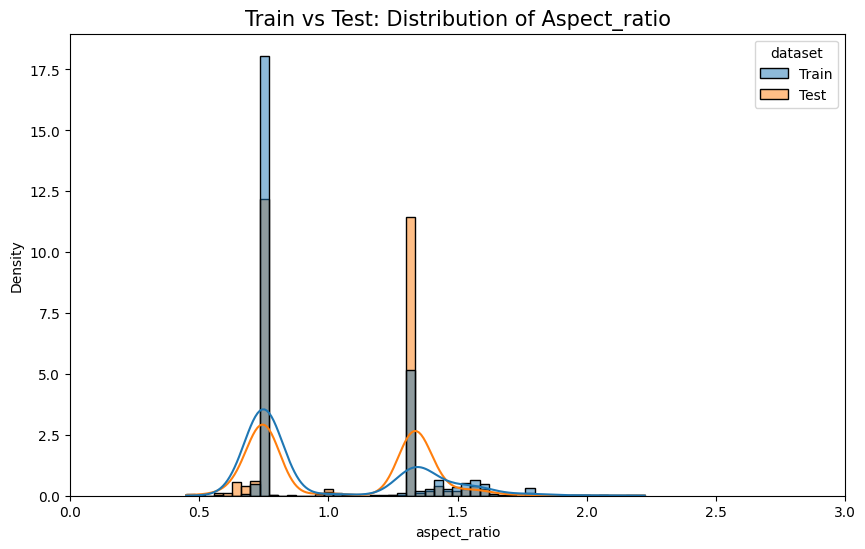

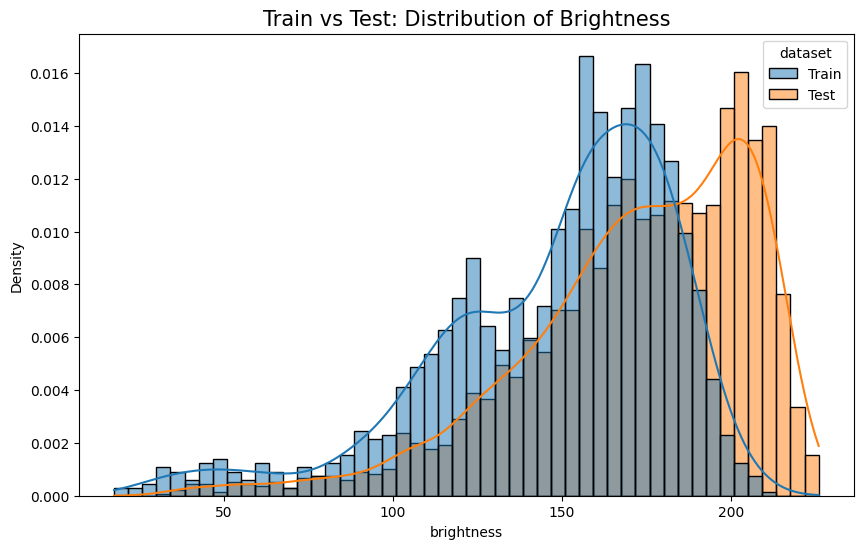

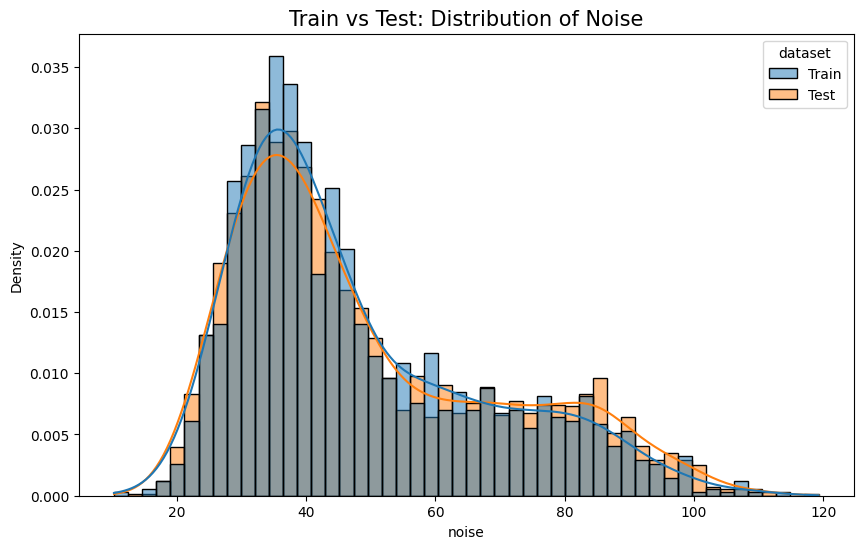


Generating class-wise plots for Train data...


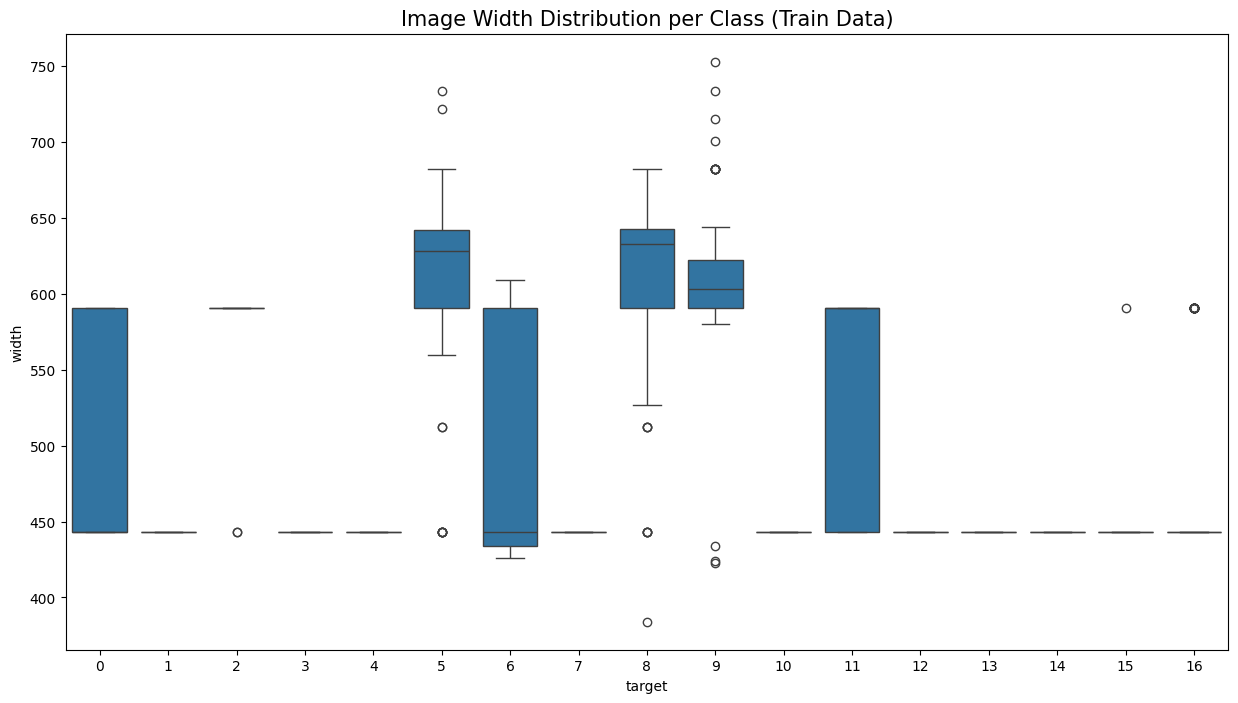

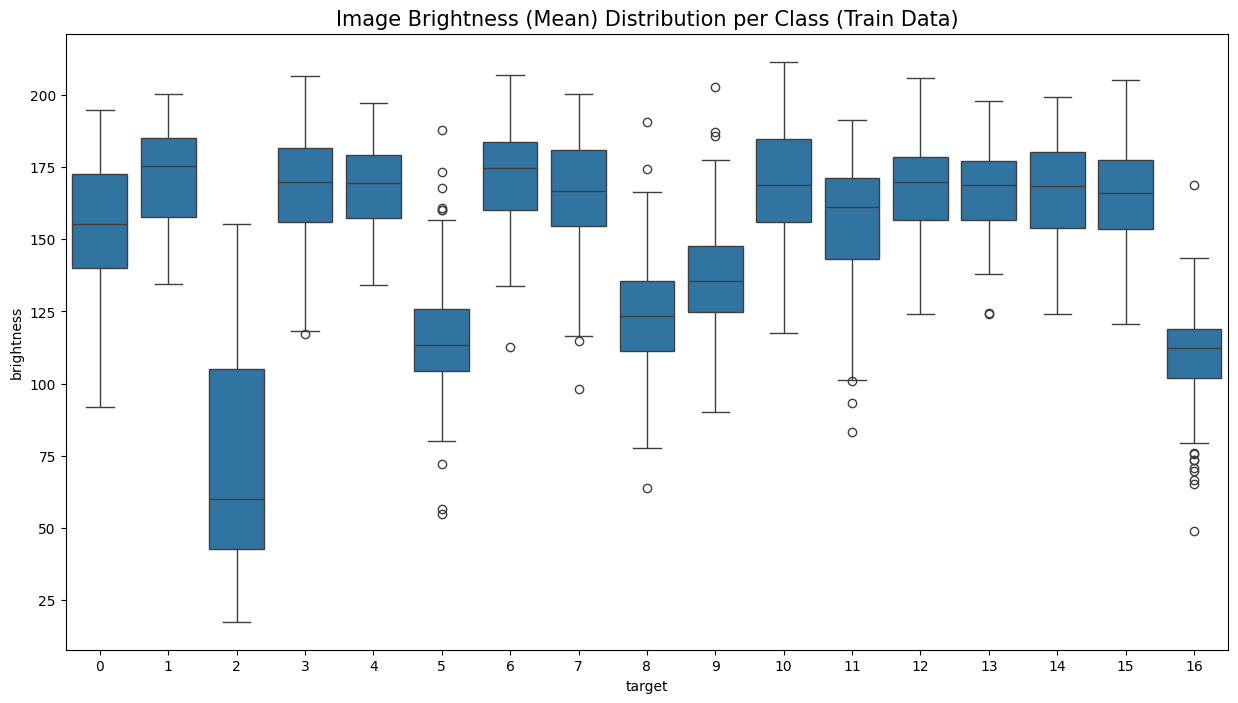

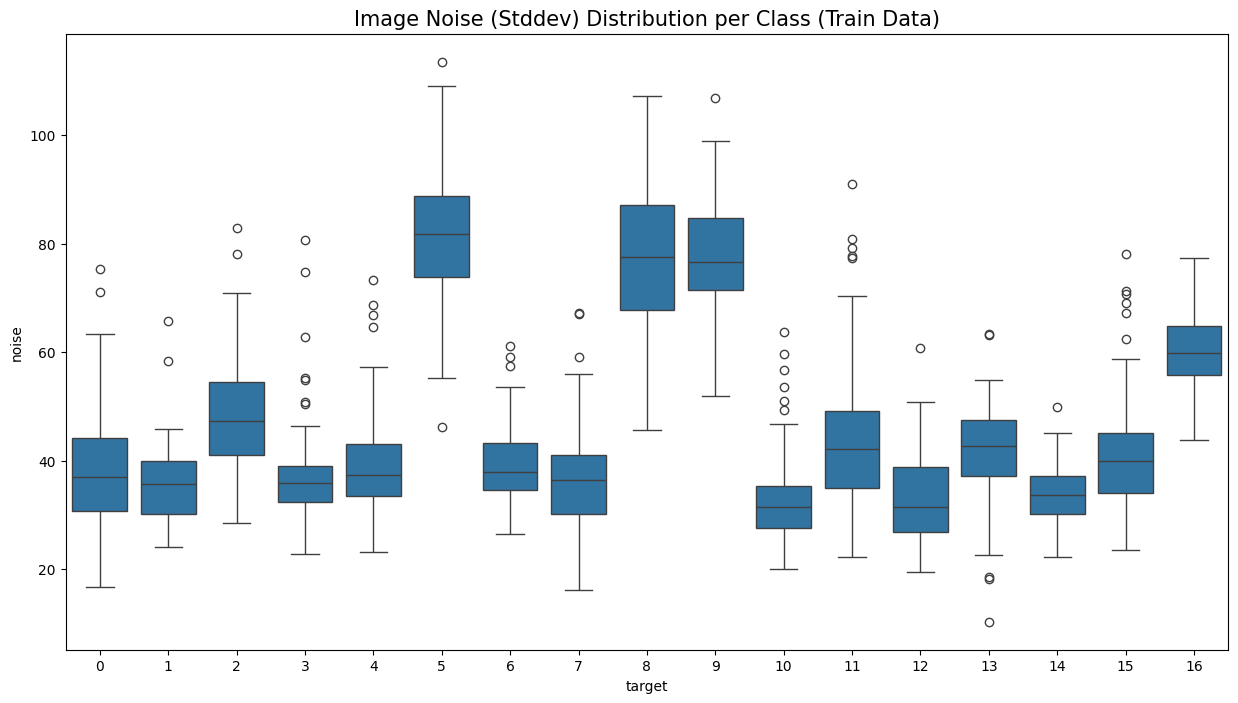


✅ All plots generated.


In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageStat
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# tqdm을 pandas와 함께 사용하기 위해 등록
tqdm.pandas()

# --- 1. 경로 설정 (사용자 환경에 맞게 확인) ---
base_path = "/root/cv_project/datasets/data"
train_csv_path = os.path.join(base_path, "train.csv")
test_csv_path = os.path.join(base_path, "sample_submission.csv")
train_base_path = os.path.join(base_path, "train")
test_base_path = os.path.join(base_path, "test")
# ------------------------------------------

# 이미지 특성 추출 함수 정의
def extract_features(df, base_path, data_type='train'):
    """
    DataFrame과 이미지 기본 경로를 받아 각 이미지의 특성을 추출합니다.
    """
    
    file_col = df.columns[0] # 'ID'
    
    # 파일이 실제로 존재하는지 먼저 확인
    print(f"Checking file existence for {data_type} data...")
    df['filepath'] = df[file_col].apply(lambda x: os.path.join(base_path, x))
    
    # 💥 중요: test 폴더 안에 하위 폴더가 있는지 확인 💥
    # 만약 test 폴더 안에 또 'test' 폴더가 있다면 경로를 수정해야 할 수 있습니다.
    # 예: test_base_path = "/root/cv_project/datasets/data/test/test"
    
    df = df[df['filepath'].apply(os.path.exists)].reset_index(drop=True)
    
    if df.empty:
        print(f"Error: No valid image files found for {data_type} data at path {base_path}")
        return pd.DataFrame()

    print(f"Extracting features from {len(df)} {data_type} images...")
    
    features = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            with Image.open(row['filepath']) as img:
                # 1. Width, Height, Aspect Ratio
                width, height = img.size
                aspect_ratio = width / height if height > 0 else 0
                
                # RGB로 변환하여 통계 계산 (컬러/흑백 이미지 통일)
                img_stat = img.convert('RGB')
                stat = ImageStat.Stat(img_stat)
                
                # 2. Brightness (Mean) - RGB 채널 평균
                mean_brightness = np.mean(stat.mean)
                
                # 3. Noise (Stddev) - RGB 채널 표준편차 평균
                mean_noise = np.mean(stat.stddev)
                
                feature_dict = {
                    'width': width,
                    'height': height,
                    'aspect_ratio': aspect_ratio,
                    'brightness': mean_brightness,
                    'noise': mean_noise
                }
                
                if data_type == 'train':
                    feature_dict['target'] = row['target']
                
                features.append(feature_dict)
        except Exception as e:
            print(f"Error processing image {row['filepath']}: {e}")
            continue
            
    return pd.DataFrame(features)

# --- 2. 데이터 로드 및 특성 추출 ---
try:
    train_df_full = pd.read_csv(train_csv_path)
    test_df_full = pd.read_csv(test_csv_path)
    
    train_features = extract_features(train_df_full, train_base_path, data_type='train')
    test_features = extract_features(test_df_full, test_base_path, data_type='test')

    # --- 3. 데이터 통합 ---
    if not train_features.empty and not test_features.empty:
        train_features['dataset'] = 'Train'
        test_features['dataset'] = 'Test'
        
        combined_df = pd.concat([
            train_features.drop(columns=['target'], errors='ignore'), 
            test_features
        ], ignore_index=True)

        print("\nFeature extraction complete. Generating plots...")

        # --- 4. Train vs Test 비교 시각화 (KDE 플롯) ---
        features_to_plot = ['width', 'height', 'aspect_ratio', 'brightness', 'noise']

        for feature in features_to_plot:
            plt.figure(figsize=(10, 6))
            # 📌 kde=True를 사용한 히스토그램이 분포 차이를 더 명확하게 보여줄 수 있습니다.
            sns.histplot(data=combined_df, x=feature, hue='dataset', kde=True, common_norm=False, stat="density", bins=50)
            plt.title(f'Train vs Test: Distribution of {feature.capitalize()}', fontsize=15)
            
            if feature == 'aspect_ratio':
                plt.xlim(0, 3) # 일반적인 비율 범위
            if feature == 'width' or feature == 'height':
                plt.xlim(0, combined_df[feature].quantile(0.99)) # 상위 1% 이상치 제외
                
            plt.show() # 👈 노트북 셀에 그래프를 바로 표시

        # --- 5. Train 데이터 클래스별 특성 시각화 (Box 플롯) ---
        print("\nGenerating class-wise plots for Train data...")
        
        plt.figure(figsize=(15, 8))
        sns.boxplot(data=train_features, x='target', y='width')
        plt.title('Image Width Distribution per Class (Train Data)', fontsize=15)
        plt.show()
        
        plt.figure(figsize=(15, 8))
        sns.boxplot(data=train_features, x='target', y='brightness')
        plt.title('Image Brightness (Mean) Distribution per Class (Train Data)', fontsize=15)
        plt.show()
        
        plt.figure(figsize=(15, 8))
        sns.boxplot(data=train_features, x='target', y='noise')
        plt.title('Image Noise (Stddev) Distribution per Class (Train Data)', fontsize=15)
        plt.show()

        print(f"\n✅ All plots generated.")
    
    else:
        print("\nCould not generate plots because one or both datasets were empty or failed to process.")

except FileNotFoundError as e:
    print(f"FATAL ERROR: CSV file not found at {e.filename}. Please check the 'base_path' variable.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [1]:
from collections import Counter
import pandas as pd

df = pd.read_csv("/root/cv_project/datasets/data/train.csv")
cnt = Counter(df["target"].tolist())
total = sum(cnt.values())

# 각 클래스 비율 보기
for k, v in sorted(cnt.items()):
    print(f"class {k:02d}: {v} ({v/total*100:.2f}%)")

print(f"\nMax/Min 비율: {max(cnt.values())/min(cnt.values()):.2f}배")


class 00: 100 (6.37%)
class 01: 46 (2.93%)
class 02: 100 (6.37%)
class 03: 100 (6.37%)
class 04: 100 (6.37%)
class 05: 100 (6.37%)
class 06: 100 (6.37%)
class 07: 100 (6.37%)
class 08: 100 (6.37%)
class 09: 100 (6.37%)
class 10: 100 (6.37%)
class 11: 100 (6.37%)
class 12: 100 (6.37%)
class 13: 74 (4.71%)
class 14: 50 (3.18%)
class 15: 100 (6.37%)
class 16: 100 (6.37%)

Max/Min 비율: 2.17배
